# Diffusion model training

#### This notebook aims to launch the training of the main diffusion model. It does not train the classifier and regressor that are used to perform *classifier* and *regressor guidance*. The trainings of the three models (diffusion model, regressor and classifier) are independant.

In [ ]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

The environment variable 'TOPODIFF_LOGDIR' defines the directory where the logs and model checkpoints will be saved.

In [ ]:
os.environ['TOPODIFF_LOGDIR'] = './checkpoints/3d_diff_logdir'

The 'TRAIN FLAGS', 'MODEL_FLAGS', 'DIFFUSION_FLAGS' and 'DATA_FLAGS' respectively set the training parameters, the model and diffusion hyperparameters and the directories where the training data are.

The default values indicated below correspond to the hyperparameters indicated in the Appendix to the paper.

In [ ]:
TRAIN_FLAGS = "--batch_size 4 --save_interval 10000 --use_fp16 True --microbatch 2"
MODEL_FLAGS = "--image_size 64 --num_channels 64 --num_res_blocks 2 --learn_sigma True --dropout 0.3 --use_checkpoint True"
DIFFUSION_FLAGS = "--diffusion_steps 1000 --noise_schedule cosine"

In order to run the training, make sure you have placed the data folder at the root of this directory.

All the images, physical fields, and load arrays must be altogether in the same folder (done by default in the data directory that we provide you with).

In [ ]:
DATA_FLAGS = "--data_dir /home/yeoneung/Euihyun/3D_TPMS_topoDIff/data"

In [ ]:
VOLUME_FLAGS = "--dims 3 --volume_size 64"

In [ ]:
%run scripts/image_train.py $MODEL_FLAGS $DIFFUSION_FLAGS $TRAIN_FLAGS $DATA_FLAGS $VOLUME_FLAGS

In [ ]:
import os
os.environ['TOPODIFF_LOGDIR'] = './checkpoints/3d_diff_logdir'

# dims 파라미터 없이, UNetModel에서 dims=3으로 하드코딩했으므로
TRAIN_FLAGS = "--batch_size 2 --save_interval 10000 --use_fp16 True"
MODEL_FLAGS = "--image_size 64 --num_channels 32 --num_res_blocks 2 --learn_sigma True --dropout 0.1 --use_checkpoint True"
DIFFUSION_FLAGS = "--diffusion_steps 1000 --noise_schedule cosine"
DATA_FLAGS = "--data_dir /home/yeoneung/Euihyun/3D_TPMS_topoDIff/data"

%run scripts/image_train.py $MODEL_FLAGS $DIFFUSION_FLAGS $TRAIN_FLAGS $DATA_FLAGS

In [ ]:
import os
os.environ['TOPODIFF_LOGDIR'] = './checkpoints/3d_diff_logdir_new'

# 모든 학습 파라미터 포함
TRAIN_FLAGS = """
--batch_size 2
--save_interval 1000 
--use_fp16 True 
--lr 5e-5 
--weight_decay 0.01
--ema_rate 0.9999
--log_interval 10
--microbatch 1
--schedule_sampler uniform
--resume_checkpoint ""
"""

MODEL_FLAGS = "--image_size 64 --num_channels 64 --num_res_blocks 2 --learn_sigma True --dropout 0.1 --use_checkpoint True"
DIFFUSION_FLAGS = "--diffusion_steps 1000 --noise_schedule cosine"
DATA_FLAGS = "--data_dir /home/yeoneung/Euihyun/3D_TPMS_topoDIff/data"

%run scripts/image_train.py $MODEL_FLAGS $DIFFUSION_FLAGS $TRAIN_FLAGS $DATA_FLAGS

Logging to ./checkpoints/3d_diff_logdir_new
Creating model and diffusion...
Model parameters: 58,794,114 total, 58,794,114 trainable
Model size: 224.3 MB (fp32)
Input shape: [batch_size, 1, 64, 64, 64]
Output channels: 2
Creating data loader...
Testing data loading...
Loading 5597 files for training
VolumeDataset initialized with 5597 volumes, target resolution: 64
Loaded test batch: shape=torch.Size([2, 1, 64, 64, 64]), range=[-1.000, 1.000], mean=-0.417
Starting training...
----------------------------
| grad_norm     | 13.8     |
| lg_loss_scale | 20       |
| loss          | 1        |
| mse           | 1        |
| param_norm    | 139      |
| samples       | 2        |
| step          | 0        |
| vb            | 0.00464  |
----------------------------
saving model 0...
saving model 0.9999...
----------------------------
| grad_norm     | 13.2     |
| lg_loss_scale | 20       |
| loss          | 0.945    |
| mse           | 0.935    |
| param_norm    | 139      |
| samples     

KeyboardInterrupt: 

In [ ]:
import os
os.environ['TOPODIFF_LOGDIR'] = './checkpoints/3d_diff_logdir_optimized_128'

# 최적화된 학습 파라미터
TRAIN_FLAGS = """
--batch_size 4
--save_interval 100 
--use_fp16 True 
--lr 1e-4 
--weight_decay 0.01
--ema_rate 0.9999
--log_interval 10
--microbatch 2
--schedule_sampler uniform
--resume_checkpoint ""
--num_workers 4
"""

# 3D에 최적화된 모델 파라미터
MODEL_FLAGS = """
--image_size 64 
--num_channels 64
--num_res_blocks 2 
--learn_sigma True 
--dropout 0.1 
--use_checkpoint True
--attention_resolutions 16,8
--channel_mult 1,2,3,4
--use_scale_shift_norm True
--resblock_updown False
--dims 3
--in_channels 1
"""

# Diffusion 파라미터
DIFFUSION_FLAGS = """
--diffusion_steps 1000 
--noise_schedule cosine
--use_kl False
--predict_xstart False
--rescale_timesteps False
"""

# 데이터 경로
DATA_FLAGS = "--data_dir /home/yeoneung/Euihyun/3D_TPMS_topoDIff/data"

# 실행
%run scripts/image_train.py $MODEL_FLAGS $DIFFUSION_FLAGS $TRAIN_FLAGS $DATA_FLAGS

Logging to ./checkpoints/3d_diff_logdir_optimized_128
Creating model and diffusion...
Model parameters: 58,794,114 total, 58,794,114 trainable
Model size: 224.3 MB (fp32)
Input shape: [batch_size, 1, 64, 64, 64]
Output channels: 2
Creating data loader...
Testing data loading...
Loading 5597 files for training
VolumeDataset initialized with 5597 volumes, target resolution: 64
Loaded test batch: shape=torch.Size([4, 1, 64, 64, 64]), range=[-1.000, 1.000], mean=-0.464
Starting training...
----------------------------
| grad_norm     | 13.5     |
| lg_loss_scale | 20       |
| loss          | 1.01     |
| mse           | 1        |
| param_norm    | 139      |
| samples       | 4        |
| step          | 0        |
| vb            | 0.00767  |
----------------------------
saving model 0...
saving model 0.9999...
----------------------------
| grad_norm     | 12.9     |
| lg_loss_scale | 20       |
| loss          | 0.882    |
| mse           | 0.868    |
| param_norm    | 139      |
| sa

In [1]:
import sys, os
# 프로젝트 루트 경로를 정확히 지정
sys.path.insert(0, '/home/yeoneung/Euihyun/3D_TPMS_topoDIff')
os.environ['TOPODIFF_LOGDIR'] = './checkpoints/3d_diff_logdir8'


# 모든 학습 파라미터 포함
TRAIN_FLAGS = """
--batch_size 4
--save_interval 100
--use_fp16 True 
--lr 5e-5 
--weight_decay 0.01
--ema_rate 0.9999
--log_interval 10
--microbatch 2
--schedule_sampler uniform
--resume_checkpoint ""
"""

MODEL_FLAGS = "--image_size 64 --num_channels 64 --num_res_blocks 2 --learn_sigma True --dropout 0.1 --use_checkpoint True"
DIFFUSION_FLAGS = "--diffusion_steps 1000 --noise_schedule cosine"
DATA_FLAGS = "--data_dir /home/yeoneung/Euihyun/3D_TPMS_topoDIff/data"

%run scripts/image_train.py \
  $MODEL_FLAGS \
  $DIFFUSION_FLAGS \
  $TRAIN_FLAGS \
  --data_dir /home/yeoneung/Euihyun/3D_TPMS_topoDIff/data

Logging to ./checkpoints/3d_diff_logdir8
Creating model and diffusion...
Model parameters: 49,420,546
Input shape: [4, 3, 64, 64, 64]
Conditioning: VF range=(0.0, 1.0), YM range=(0.0, 1600.0)
Creating data loader...
Starting training...
TRAIN: 5823 files
VF range: (0.0, 1.0), YM range: (0.0, 1600.0)
----------------------------
| cond_vf_mean  | 0.242    |
| cond_ym_mean  | 0.0798   |
| grad_norm     | 19.1     |
| lg_loss_scale | 20       |
| loss          | 1.15     |
| loss_q0       | 1.02     |
| loss_q3       | 1.29     |
| mse           | 1        |
| mse_q0        | 0.999    |
| mse_q3        | 1        |
| param_norm    | 132      |
| samples       | 4        |
| step          | 0        |
| vb            | 0.153    |
| vb_q0         | 0.0198   |
| vb_q3         | 0.286    |
----------------------------
saving model 0...
saving model 0.9999...
Skipping meta save (no dataset): 'generator' object has no attribute 'dataset'
----------------------------
| cond_vf_mean  | 0.304    |

KeyboardInterrupt: 

In [1]:
import sys, os
# 프로젝트 루트 경로를 정확히 지정
sys.path.insert(0, '/home/yeoneung/Euihyun/3D_TPMS_topoDIff')
os.environ['TOPODIFF_LOGDIR'] = './checkpoints/3d_diff_logdir10'


# 모든 학습 파라미터 포함
TRAIN_FLAGS = """
--batch_size 4
--save_interval 100
--use_fp16 False 
--lr 5e-5 
--weight_decay 0.01
--ema_rate 0.9999
--log_interval 10
--microbatch 2
--schedule_sampler uniform
--resume_checkpoint ""
"""

MODEL_FLAGS = "--image_size 64 --num_channels 32 --num_res_blocks 2 --learn_sigma True --dropout 0.1 --use_checkpoint True"
DIFFUSION_FLAGS = "--diffusion_steps 1000 --noise_schedule cosine"
DATA_FLAGS = "--data_dir /home/yeoneung/Euihyun/3D_TPMS_topoDIff/data"

%run scripts/image_train.py \
  $MODEL_FLAGS \
  $DIFFUSION_FLAGS \
  $TRAIN_FLAGS \
  --data_dir /home/yeoneung/Euihyun/3D_TPMS_topoDIff/data

Logging to ./checkpoints/3d_diff_logdir10
Creating model and diffusion...
Model parameters: 12,367,298
Input shape: [4, 3, 64, 64, 64]
Conditioning: VF range=(0.0, 1.0), YM range=(0.0, 1600.0)
Creating data loader...
Starting training...
TRAIN: 5823 files
VF range: (0.0, 1.0), YM range: (0.0, 1600.0)
---------------------------
| cond_vf_mean | 0.5      |
| cond_ym_mean | 0.5      |
| grad_norm    | 20.7     |
| loss         | 1        |
| loss_q1      | 1        |
| loss_q2      | 1.01     |
| mse          | 1        |
| mse_q1       | 0.996    |
| mse_q2       | 1        |
| param_norm   | 93.1     |
| samples      | 4        |
| step         | 0        |
| vb           | 0.00478  |
| vb_q1        | 0.00483  |
| vb_q2        | 0.00476  |
---------------------------
saving model 0...
saving model 0.9999...
Skipping meta save (no dataset): 'generator' object has no attribute 'dataset'
---------------------------
| cond_vf_mean | 0.5      |
| cond_ym_mean | 0.5      |
| grad_norm    | 1

KeyboardInterrupt: 

In [5]:
# Jupyter에서 실행
import sys, os
sys.path.insert(0, '/home/yeoneung/Euihyun/3D_TPMS_topoDIff')

MODEL_FLAGS = """
--image_size 64 
--num_channels 32
--num_res_blocks 2
--attention_resolutions 16,8
--channel_mult 1,2,2,4
--learn_sigma True
--use_fp16 False
"""

DIFFUSION_FLAGS = """
--diffusion_steps 1000
--timestep_respacing 100
--noise_schedule cosine
"""

SAMPLE_FLAGS = """
--num_samples 1
--batch_size 4
--target_vf 0.3
--target_ym 50.0
--output_dir ./generated/samples/vf0.3_ym50
--visualize True
--clip_denoised True
"""

PATHS = "--model_path ./checkpoints/3d_diff_logdir10/ema_0.9999_002100.pt"

%run scripts/topodiff_sample.py $MODEL_FLAGS $DIFFUSION_FLAGS $SAMPLE_FLAGS $PATHS

Logging to /tmp/topodiff-2025-06-10-16-39-01-702738
Creating model and diffusion...
Loading model from ./checkpoints/3d_diff_logdir10/ema_0.9999_002100.pt...
No meta.pt found, calculating from data...
Calculating VF/YM ranges from data...
Calculated VF range: (0.07453536987304688, 0.8730812072753906)
Calculated YM range: (0.0, 1154.5745849609375)
Starting sampling...
Target conditions: VF=0.3, YM=50.0
Using ranges: VF=(0.07453536987304688, 0.8730812072753906), YM=(0.0, 1154.5745849609375)


Generating samples:   0%|          | 0/1 [00:00<?, ?it/s]

🔧 Unconditional sampling (ignoring VF=0.3, YM=50.0)
Sampling shape: (1, 1, 64, 64, 64)


100%|██████████| 100/100 [00:09<00:00, 10.97it/s]

Generated samples shape: torch.Size([1, 1, 64, 64, 64])
Sample stats: mean=0.000, std=0.720
Sample range: [-1.000, 1.000]



Generating samples: 100%|██████████| 1/1 [00:09<00:00,  9.12s/it]

Saving samples...
Saving 1 samples...


Creating visualizations for 1 samples...
Saved visualizations to ./generated/samples/vf0.3_ym50/visualizations
Sampling complete! Saved to ./generated/samples/vf0.3_ym50


Structure mean: 0.000
Structure std:  0.720
Min / Max:      -1.000 / 1.000
Actual VF (vol>0): 0.500


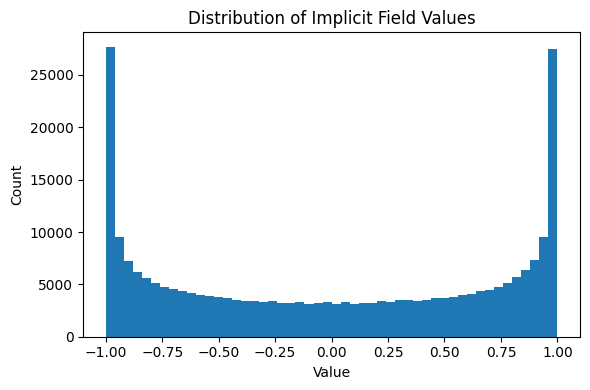

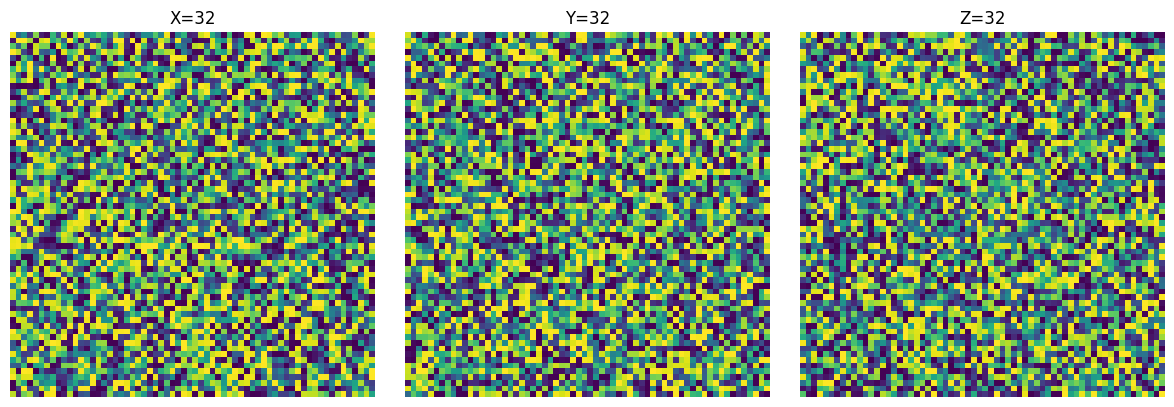

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# === 사용자 환경에 맞게 파일 경로 수정 ===
file_path = '/home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/generated/samples/vf0.3_ym50/generated_vf0.300_ym50.0_sample0000.npz'

# 1) .npz 파일 로드
data = np.load(file_path)
vol = data['structure']  # (64,64,64)

# 2) 주요 통계 지표 계산
mean_val = vol.mean()
std_val = vol.std()
min_val = vol.min()
max_val = vol.max()
# 임계치(>0) 기준 실제 VF 계산
actual_vf = float((vol > 0).mean())

print(f"Structure mean: {mean_val:.3f}")
print(f"Structure std:  {std_val:.3f}")
print(f"Min / Max:      {min_val:.3f} / {max_val:.3f}")
print(f"Actual VF (vol>0): {actual_vf:.3f}")

# 3) 히스토그램 그리기
plt.figure(figsize=(6,4))
plt.hist(vol.flatten(), bins=50)
plt.title('Distribution of Implicit Field Values')
plt.xlabel('Value')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 4) 세 방향 슬라이스 다시 시각화 (컬러맵과 축 제거)
slices = {
    'X=32': vol[32, :, :],
    'Y=32': vol[:, 32, :],
    'Z=32': vol[:, :, 32],
}
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for ax, (title, slc) in zip(axes, slices.items()):
    im = ax.imshow(slc, interpolation='nearest')
    ax.set_title(title)
    ax.axis('off')
fig.tight_layout()
plt.show()


In [2]:
"""
학습된 모델의 정확한 동작 방식 확인
프로젝트 루트에서 실행: python model_debug_script.py
"""

import sys
import os
import torch as th
import numpy as np

# 프로젝트 경로 추가
sys.path.insert(0, '/home/yeoneung/Euihyun/3D_TPMS_topoDIff')

from topodiff import dist_util
from topodiff.script_util import create_model_and_diffusion, model_and_diffusion_defaults
from topodiff.image_datasets_diffusion_model import load_data

def test_trained_model():
    """학습된 모델의 정확한 동작 확인"""
    
    print("🔍 학습된 모델 분석 시작...")
    
    # 1. 모델 로드
    print("\n1️⃣ 모델 로드")
    model, diffusion = create_model_and_diffusion(**model_and_diffusion_defaults())
    
    model_path = "./checkpoints/3d_diff_logdir6/model011000.pt"
    state_dict = th.load(model_path, map_location='cpu')
    model.load_state_dict(state_dict)
    model.eval()
    
    print(f"✅ 모델 로드 완료")
    print(f"✅ 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")
    
    # 2. 학습 데이터 확인
    print("\n2️⃣ 학습 데이터 포맷 확인")
    data_dir = "/home/yeoneung/Euihyun/3D_TPMS_topoDIff/data"
    
    try:
        data = load_data(
            data_dir=data_dir,
            batch_size=1,
            image_size=64,
            split='train',
            num_workers=1
        )
        
        batch, cond_dict = next(data)
        print(f"✅ 학습 데이터 로드 성공")
        print(f"✅ 배치 형태: {batch.shape}")
        print(f"✅ 조건 키: {cond_dict.keys()}")
        print(f"✅ 조건값 - VF: {cond_dict['target_vf'].item():.3f}, YM: {cond_dict['target_ym'].item():.3f}")
        
        # 채널별 분석
        print(f"\n📊 채널별 분석:")
        print(f"   채널 0 (구조): mean={batch[0,0].mean():.3f}, std={batch[0,0].std():.3f}, range=[{batch[0,0].min():.3f}, {batch[0,0].max():.3f}]")
        print(f"   채널 1 (VF):   mean={batch[0,1].mean():.3f}, std={batch[0,1].std():.6f}")
        print(f"   채널 2 (YM):   mean={batch[0,2].mean():.3f}, std={batch[0,2].std():.6f}")
        
        # VF, YM이 상수인지 확인
        vf_unique = th.unique(batch[0,1])
        ym_unique = th.unique(batch[0,2])
        print(f"   VF 고유값 개수: {len(vf_unique)} (상수인지: {len(vf_unique) == 1})")
        print(f"   YM 고유값 개수: {len(ym_unique)} (상수인지: {len(ym_unique) == 1})")
        
        training_sample = batch
        training_cond = cond_dict
        
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return False
    
    # 3. 모델 Forward 테스트
    print("\n3️⃣ 모델 Forward 테스트")
    
    with th.no_grad():
        # 학습 데이터로 테스트
        output = model(training_sample, th.tensor([500]))
        
        print(f"✅ 모델 출력 성공")
        print(f"✅ 입력 형태: {training_sample.shape}")
        print(f"✅ 출력 형태: {output.shape}")
        print(f"✅ 출력 범위: [{output.min():.3f}, {output.max():.3f}]")
        
        # learn_sigma 확인
        learn_sigma = output.shape[1] == 6
        print(f"✅ learn_sigma: {learn_sigma} ({'6채널' if learn_sigma else '3채널'} 출력)")
        
        if learn_sigma:
            mean_pred = output[:, :3]
            var_pred = output[:, 3:]
            print(f"   평균 예측: {mean_pred.shape}, 범위: [{mean_pred.min():.3f}, {mean_pred.max():.3f}]")
            print(f"   분산 예측: {var_pred.shape}, 범위: [{var_pred.min():.3f}, {var_pred.max():.3f}]")
        
    # 4. 노이즈 추가 테스트 (학습 시와 동일)
    print("\n4️⃣ 노이즈 추가 테스트 (q_sample_conditional)")
    
    t = th.tensor([500])  # 중간 타임스텝
    noise = th.randn_like(training_sample[:, :1])  # 구조 채널만
    
    # q_sample_conditional 호출
    noisy_sample = diffusion.q_sample_conditional(training_sample, t, noise)
    
    print(f"✅ 노이즈 추가 완료")
    print(f"✅ 원본 vs 노이즈: 구조 채널 std {training_sample[0,0].std():.3f} -> {noisy_sample[0,0].std():.3f}")
    print(f"✅ 조건 채널 유지: VF {noisy_sample[0,1].mean():.3f} (원본: {training_sample[0,1].mean():.3f})")
    print(f"✅ 조건 채널 유지: YM {noisy_sample[0,2].mean():.3f} (원본: {training_sample[0,2].mean():.3f})")
    
    # 5. 샘플링 스텝 시뮬레이션
    print("\n5️⃣ 샘플링 스텝 시뮬레이션")
    
    # 조건값 설정
    target_vf = 0.3
    target_ym = 50.0
    
    # 정규화 (데이터셋에서 가져온 범위 사용)
    dataset = load_data(data_dir=data_dir, batch_size=1, image_size=64, split='train', num_workers=1)
    sample_batch, _ = next(dataset)
    
    # VolumeDataset 인스턴스에서 범위 가져오기 (임시 방법)
    vf_range = (0.1, 0.9)  # 임시값, 실제로는 dataset에서 가져와야 함
    ym_range = (10.0, 300.0)  # 임시값
    
    vf_norm = (target_vf - vf_range[0]) / (vf_range[1] - vf_range[0])
    ym_norm = (target_ym - ym_range[0]) / (ym_range[1] - ym_range[0])
    
    print(f"   타겟 조건: VF={target_vf}, YM={target_ym}")
    print(f"   정규화된 조건: VF={vf_norm:.3f}, YM={ym_norm:.3f}")
    
    # 샘플링용 초기 텐서 생성
    sample_img = th.zeros(1, 3, 64, 64, 64)
    sample_img[:, 0] = th.randn(1, 64, 64, 64)  # 구조는 노이즈
    sample_img[:, 1] = vf_norm  # VF 조건
    sample_img[:, 2] = ym_norm  # YM 조건
    
    print(f"   샘플링 초기 텐서: {sample_img.shape}")
    print(f"   초기 조건 확인: VF={sample_img[0,1].mean():.3f}, YM={sample_img[0,2].mean():.3f}")
    
    # 모델 예측
    with th.no_grad():
        sample_output = model(sample_img, th.tensor([500]))
        print(f"   샘플링 모델 출력: {sample_output.shape}")
        print(f"   출력 범위: [{sample_output.min():.3f}, {sample_output.max():.3f}]")
    
    # 6. 결론
    print("\n📋 분석 결과:")
    print("✅ 모델이 정상적으로 로드됨")
    print("✅ 학습 데이터 포맷 확인됨 (3채널: 구조+VF+YM)")
    print("✅ 조건이 상수맵으로 브로드캐스트됨")
    print("✅ 모델이 조건 포함 입력을 받아 처리함")
    
    return True

def check_sampling_consistency():
    """샘플링 일관성 확인"""
    print("\n🔄 샘플링 일관성 체크")
    
    # p_sample_loop_progressive에서 조건 유지가 되는지 확인
    # 이 부분은 실제 샘플링 코드 실행 필요
    
    print("⚠️  샘플링 과정에서 확인할 사항:")
    print("   1. 각 디노이징 스텝에서 조건 채널이 유지되는가?")
    print("   2. 구조 채널만 업데이트되고 조건은 고정되는가?")
    print("   3. 정규화 범위가 학습 시와 일치하는가?")

if __name__ == "__main__":
    success = test_trained_model()
    if success:
        check_sampling_consistency()
    else:
        print("❌ 모델 분석 실패")

🔍 학습된 모델 분석 시작...

1️⃣ 모델 로드


/tmp/ipykernel_3695256/3728220379.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = th.load(model_path, map_location='cpu')


RuntimeError: Error(s) in loading state_dict for UNetModel:
	Missing key(s) in state_dict: "input_blocks.3.0.in_layers.0.weight", "input_blocks.3.0.in_layers.0.bias", "input_blocks.3.0.in_layers.2.weight", "input_blocks.3.0.in_layers.2.bias", "input_blocks.3.0.emb_layers.1.weight", "input_blocks.3.0.emb_layers.1.bias", "input_blocks.3.0.out_layers.0.weight", "input_blocks.3.0.out_layers.0.bias", "input_blocks.3.0.out_layers.3.weight", "input_blocks.3.0.out_layers.3.bias", "input_blocks.4.0.op.weight", "input_blocks.4.0.op.bias", "input_blocks.5.0.skip_connection.weight", "input_blocks.5.0.skip_connection.bias", "input_blocks.6.0.in_layers.0.weight", "input_blocks.6.0.in_layers.0.bias", "input_blocks.6.0.in_layers.2.weight", "input_blocks.6.0.in_layers.2.bias", "input_blocks.6.0.emb_layers.1.weight", "input_blocks.6.0.emb_layers.1.bias", "input_blocks.6.0.out_layers.0.weight", "input_blocks.6.0.out_layers.0.bias", "input_blocks.6.0.out_layers.3.weight", "input_blocks.6.0.out_layers.3.bias", "input_blocks.8.0.op.weight", "input_blocks.8.0.op.bias", "input_blocks.9.0.in_layers.0.weight", "input_blocks.9.0.in_layers.0.bias", "input_blocks.9.0.in_layers.2.weight", "input_blocks.9.0.in_layers.2.bias", "input_blocks.9.0.emb_layers.1.weight", "input_blocks.9.0.emb_layers.1.bias", "input_blocks.9.0.out_layers.0.weight", "input_blocks.9.0.out_layers.0.bias", "input_blocks.9.0.out_layers.3.weight", "input_blocks.9.0.out_layers.3.bias", "input_blocks.9.1.norm.weight", "input_blocks.9.1.norm.bias", "input_blocks.9.1.qkv.weight", "input_blocks.9.1.qkv.bias", "input_blocks.9.1.proj_out.weight", "input_blocks.9.1.proj_out.bias", "input_blocks.12.0.op.weight", "input_blocks.12.0.op.bias", "input_blocks.13.0.in_layers.0.weight", "input_blocks.13.0.in_layers.0.bias", "input_blocks.13.0.in_layers.2.weight", "input_blocks.13.0.in_layers.2.bias", "input_blocks.13.0.emb_layers.1.weight", "input_blocks.13.0.emb_layers.1.bias", "input_blocks.13.0.out_layers.0.weight", "input_blocks.13.0.out_layers.0.bias", "input_blocks.13.0.out_layers.3.weight", "input_blocks.13.0.out_layers.3.bias", "input_blocks.13.0.skip_connection.weight", "input_blocks.13.0.skip_connection.bias", "input_blocks.13.1.norm.weight", "input_blocks.13.1.norm.bias", "input_blocks.13.1.qkv.weight", "input_blocks.13.1.qkv.bias", "input_blocks.13.1.proj_out.weight", "input_blocks.13.1.proj_out.bias", "input_blocks.14.0.in_layers.0.weight", "input_blocks.14.0.in_layers.0.bias", "input_blocks.14.0.in_layers.2.weight", "input_blocks.14.0.in_layers.2.bias", "input_blocks.14.0.emb_layers.1.weight", "input_blocks.14.0.emb_layers.1.bias", "input_blocks.14.0.out_layers.0.weight", "input_blocks.14.0.out_layers.0.bias", "input_blocks.14.0.out_layers.3.weight", "input_blocks.14.0.out_layers.3.bias", "input_blocks.14.1.norm.weight", "input_blocks.14.1.norm.bias", "input_blocks.14.1.qkv.weight", "input_blocks.14.1.qkv.bias", "input_blocks.14.1.proj_out.weight", "input_blocks.14.1.proj_out.bias", "input_blocks.15.0.in_layers.0.weight", "input_blocks.15.0.in_layers.0.bias", "input_blocks.15.0.in_layers.2.weight", "input_blocks.15.0.in_layers.2.bias", "input_blocks.15.0.emb_layers.1.weight", "input_blocks.15.0.emb_layers.1.bias", "input_blocks.15.0.out_layers.0.weight", "input_blocks.15.0.out_layers.0.bias", "input_blocks.15.0.out_layers.3.weight", "input_blocks.15.0.out_layers.3.bias", "input_blocks.15.1.norm.weight", "input_blocks.15.1.norm.bias", "input_blocks.15.1.qkv.weight", "input_blocks.15.1.qkv.bias", "input_blocks.15.1.proj_out.weight", "input_blocks.15.1.proj_out.bias", "output_blocks.3.2.conv.weight", "output_blocks.3.2.conv.bias", "output_blocks.6.1.norm.weight", "output_blocks.6.1.norm.bias", "output_blocks.6.1.qkv.weight", "output_blocks.6.1.qkv.bias", "output_blocks.6.1.proj_out.weight", "output_blocks.6.1.proj_out.bias", "output_blocks.7.1.norm.weight", "output_blocks.7.1.norm.bias", "output_blocks.7.1.qkv.weight", "output_blocks.7.1.qkv.bias", "output_blocks.7.1.proj_out.weight", "output_blocks.7.1.proj_out.bias", "output_blocks.7.2.conv.weight", "output_blocks.7.2.conv.bias", "output_blocks.11.1.conv.weight", "output_blocks.11.1.conv.bias", "output_blocks.12.0.in_layers.0.weight", "output_blocks.12.0.in_layers.0.bias", "output_blocks.12.0.in_layers.2.weight", "output_blocks.12.0.in_layers.2.bias", "output_blocks.12.0.emb_layers.1.weight", "output_blocks.12.0.emb_layers.1.bias", "output_blocks.12.0.out_layers.0.weight", "output_blocks.12.0.out_layers.0.bias", "output_blocks.12.0.out_layers.3.weight", "output_blocks.12.0.out_layers.3.bias", "output_blocks.12.0.skip_connection.weight", "output_blocks.12.0.skip_connection.bias", "output_blocks.13.0.in_layers.0.weight", "output_blocks.13.0.in_layers.0.bias", "output_blocks.13.0.in_layers.2.weight", "output_blocks.13.0.in_layers.2.bias", "output_blocks.13.0.emb_layers.1.weight", "output_blocks.13.0.emb_layers.1.bias", "output_blocks.13.0.out_layers.0.weight", "output_blocks.13.0.out_layers.0.bias", "output_blocks.13.0.out_layers.3.weight", "output_blocks.13.0.out_layers.3.bias", "output_blocks.13.0.skip_connection.weight", "output_blocks.13.0.skip_connection.bias", "output_blocks.14.0.in_layers.0.weight", "output_blocks.14.0.in_layers.0.bias", "output_blocks.14.0.in_layers.2.weight", "output_blocks.14.0.in_layers.2.bias", "output_blocks.14.0.emb_layers.1.weight", "output_blocks.14.0.emb_layers.1.bias", "output_blocks.14.0.out_layers.0.weight", "output_blocks.14.0.out_layers.0.bias", "output_blocks.14.0.out_layers.3.weight", "output_blocks.14.0.out_layers.3.bias", "output_blocks.14.0.skip_connection.weight", "output_blocks.14.0.skip_connection.bias", "output_blocks.15.0.in_layers.0.weight", "output_blocks.15.0.in_layers.0.bias", "output_blocks.15.0.in_layers.2.weight", "output_blocks.15.0.in_layers.2.bias", "output_blocks.15.0.emb_layers.1.weight", "output_blocks.15.0.emb_layers.1.bias", "output_blocks.15.0.out_layers.0.weight", "output_blocks.15.0.out_layers.0.bias", "output_blocks.15.0.out_layers.3.weight", "output_blocks.15.0.out_layers.3.bias", "output_blocks.15.0.skip_connection.weight", "output_blocks.15.0.skip_connection.bias". 
	Unexpected key(s) in state_dict: "input_blocks.3.0.op.weight", "input_blocks.3.0.op.bias", "input_blocks.4.0.in_layers.0.weight", "input_blocks.4.0.in_layers.0.bias", "input_blocks.4.0.in_layers.2.weight", "input_blocks.4.0.in_layers.2.bias", "input_blocks.4.0.emb_layers.1.weight", "input_blocks.4.0.emb_layers.1.bias", "input_blocks.4.0.out_layers.0.weight", "input_blocks.4.0.out_layers.0.bias", "input_blocks.4.0.out_layers.3.weight", "input_blocks.4.0.out_layers.3.bias", "input_blocks.4.0.skip_connection.weight", "input_blocks.4.0.skip_connection.bias", "input_blocks.6.0.op.weight", "input_blocks.6.0.op.bias", "input_blocks.7.1.norm.weight", "input_blocks.7.1.norm.bias", "input_blocks.7.1.qkv.weight", "input_blocks.7.1.qkv.bias", "input_blocks.7.1.proj_out.weight", "input_blocks.7.1.proj_out.bias", "input_blocks.8.1.norm.weight", "input_blocks.8.1.norm.bias", "input_blocks.8.1.qkv.weight", "input_blocks.8.1.qkv.bias", "input_blocks.8.1.proj_out.weight", "input_blocks.8.1.proj_out.bias", "input_blocks.8.0.in_layers.0.weight", "input_blocks.8.0.in_layers.0.bias", "input_blocks.8.0.in_layers.2.weight", "input_blocks.8.0.in_layers.2.bias", "input_blocks.8.0.emb_layers.1.weight", "input_blocks.8.0.emb_layers.1.bias", "input_blocks.8.0.out_layers.0.weight", "input_blocks.8.0.out_layers.0.bias", "input_blocks.8.0.out_layers.3.weight", "input_blocks.8.0.out_layers.3.bias", "input_blocks.9.0.op.weight", "input_blocks.9.0.op.bias", "input_blocks.10.0.skip_connection.weight", "input_blocks.10.0.skip_connection.bias", "output_blocks.2.2.conv.weight", "output_blocks.2.2.conv.bias", "output_blocks.5.2.conv.weight", "output_blocks.5.2.conv.bias", "output_blocks.8.1.conv.weight", "output_blocks.8.1.conv.bias". 
	size mismatch for time_embed.0.weight: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for time_embed.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for time_embed.2.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for time_embed.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for input_blocks.0.0.weight: copying a param with shape torch.Size([64, 3, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 3, 3, 3, 3]).
	size mismatch for input_blocks.0.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for input_blocks.1.0.in_layers.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for input_blocks.1.0.in_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for input_blocks.1.0.in_layers.2.weight: copying a param with shape torch.Size([64, 64, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3, 3]).
	size mismatch for input_blocks.1.0.in_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for input_blocks.1.0.emb_layers.1.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for input_blocks.1.0.emb_layers.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for input_blocks.1.0.out_layers.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for input_blocks.1.0.out_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for input_blocks.1.0.out_layers.3.weight: copying a param with shape torch.Size([64, 64, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3, 3]).
	size mismatch for input_blocks.1.0.out_layers.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for input_blocks.2.0.in_layers.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for input_blocks.2.0.in_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for input_blocks.2.0.in_layers.2.weight: copying a param with shape torch.Size([64, 64, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3, 3]).
	size mismatch for input_blocks.2.0.in_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for input_blocks.2.0.emb_layers.1.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for input_blocks.2.0.emb_layers.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for input_blocks.2.0.out_layers.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for input_blocks.2.0.out_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for input_blocks.2.0.out_layers.3.weight: copying a param with shape torch.Size([64, 64, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3, 3]).
	size mismatch for input_blocks.2.0.out_layers.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for input_blocks.5.0.in_layers.2.weight: copying a param with shape torch.Size([128, 128, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3, 3]).
	size mismatch for input_blocks.5.0.in_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for input_blocks.5.0.emb_layers.1.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for input_blocks.5.0.emb_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for input_blocks.5.0.out_layers.0.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for input_blocks.5.0.out_layers.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for input_blocks.5.0.out_layers.3.weight: copying a param with shape torch.Size([128, 128, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3, 3]).
	size mismatch for input_blocks.5.0.out_layers.3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for input_blocks.7.0.in_layers.0.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for input_blocks.7.0.in_layers.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for input_blocks.7.0.in_layers.2.weight: copying a param with shape torch.Size([128, 128, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3, 3]).
	size mismatch for input_blocks.7.0.in_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for input_blocks.7.0.emb_layers.1.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for input_blocks.7.0.emb_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for input_blocks.7.0.out_layers.0.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for input_blocks.7.0.out_layers.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for input_blocks.7.0.out_layers.3.weight: copying a param with shape torch.Size([128, 128, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3, 3]).
	size mismatch for input_blocks.7.0.out_layers.3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for input_blocks.10.0.in_layers.0.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for input_blocks.10.0.in_layers.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for input_blocks.10.0.in_layers.2.weight: copying a param with shape torch.Size([256, 128, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3, 3]).
	size mismatch for input_blocks.10.0.emb_layers.1.weight: copying a param with shape torch.Size([512, 256]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for input_blocks.11.0.emb_layers.1.weight: copying a param with shape torch.Size([512, 256]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for middle_block.0.in_layers.0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for middle_block.0.in_layers.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for middle_block.0.in_layers.2.weight: copying a param with shape torch.Size([256, 256, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3, 3]).
	size mismatch for middle_block.0.in_layers.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for middle_block.0.emb_layers.1.weight: copying a param with shape torch.Size([512, 256]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for middle_block.0.emb_layers.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for middle_block.0.out_layers.0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for middle_block.0.out_layers.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for middle_block.0.out_layers.3.weight: copying a param with shape torch.Size([256, 256, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3, 3]).
	size mismatch for middle_block.0.out_layers.3.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for middle_block.1.norm.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for middle_block.1.norm.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for middle_block.1.qkv.weight: copying a param with shape torch.Size([768, 256, 1]) from checkpoint, the shape in current model is torch.Size([1536, 512, 1]).
	size mismatch for middle_block.1.qkv.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for middle_block.1.proj_out.weight: copying a param with shape torch.Size([256, 256, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1]).
	size mismatch for middle_block.1.proj_out.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for middle_block.2.in_layers.0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for middle_block.2.in_layers.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for middle_block.2.in_layers.2.weight: copying a param with shape torch.Size([256, 256, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3, 3]).
	size mismatch for middle_block.2.in_layers.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for middle_block.2.emb_layers.1.weight: copying a param with shape torch.Size([512, 256]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for middle_block.2.emb_layers.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for middle_block.2.out_layers.0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for middle_block.2.out_layers.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for middle_block.2.out_layers.3.weight: copying a param with shape torch.Size([256, 256, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3, 3]).
	size mismatch for middle_block.2.out_layers.3.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.0.0.in_layers.0.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for output_blocks.0.0.in_layers.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for output_blocks.0.0.in_layers.2.weight: copying a param with shape torch.Size([256, 512, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1024, 3, 3, 3]).
	size mismatch for output_blocks.0.0.in_layers.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.0.0.emb_layers.1.weight: copying a param with shape torch.Size([512, 256]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for output_blocks.0.0.emb_layers.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for output_blocks.0.0.out_layers.0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.0.0.out_layers.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.0.0.out_layers.3.weight: copying a param with shape torch.Size([256, 256, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3, 3]).
	size mismatch for output_blocks.0.0.out_layers.3.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.0.0.skip_connection.weight: copying a param with shape torch.Size([256, 512, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 1024, 1, 1, 1]).
	size mismatch for output_blocks.0.0.skip_connection.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.0.1.norm.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.0.1.norm.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.0.1.qkv.weight: copying a param with shape torch.Size([768, 256, 1]) from checkpoint, the shape in current model is torch.Size([1536, 512, 1]).
	size mismatch for output_blocks.0.1.qkv.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for output_blocks.0.1.proj_out.weight: copying a param with shape torch.Size([256, 256, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1]).
	size mismatch for output_blocks.0.1.proj_out.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.1.0.in_layers.0.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for output_blocks.1.0.in_layers.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for output_blocks.1.0.in_layers.2.weight: copying a param with shape torch.Size([256, 512, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1024, 3, 3, 3]).
	size mismatch for output_blocks.1.0.in_layers.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.1.0.emb_layers.1.weight: copying a param with shape torch.Size([512, 256]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for output_blocks.1.0.emb_layers.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for output_blocks.1.0.out_layers.0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.1.0.out_layers.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.1.0.out_layers.3.weight: copying a param with shape torch.Size([256, 256, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3, 3]).
	size mismatch for output_blocks.1.0.out_layers.3.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.1.0.skip_connection.weight: copying a param with shape torch.Size([256, 512, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 1024, 1, 1, 1]).
	size mismatch for output_blocks.1.0.skip_connection.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.1.1.norm.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.1.1.norm.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.1.1.qkv.weight: copying a param with shape torch.Size([768, 256, 1]) from checkpoint, the shape in current model is torch.Size([1536, 512, 1]).
	size mismatch for output_blocks.1.1.qkv.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for output_blocks.1.1.proj_out.weight: copying a param with shape torch.Size([256, 256, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1]).
	size mismatch for output_blocks.1.1.proj_out.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.2.0.in_layers.0.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for output_blocks.2.0.in_layers.0.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for output_blocks.2.0.in_layers.2.weight: copying a param with shape torch.Size([256, 384, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1024, 3, 3, 3]).
	size mismatch for output_blocks.2.0.in_layers.2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.2.0.emb_layers.1.weight: copying a param with shape torch.Size([512, 256]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for output_blocks.2.0.emb_layers.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for output_blocks.2.0.out_layers.0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.2.0.out_layers.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.2.0.out_layers.3.weight: copying a param with shape torch.Size([256, 256, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3, 3]).
	size mismatch for output_blocks.2.0.out_layers.3.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.2.0.skip_connection.weight: copying a param with shape torch.Size([256, 384, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 1024, 1, 1, 1]).
	size mismatch for output_blocks.2.0.skip_connection.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.2.1.norm.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.2.1.norm.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.2.1.qkv.weight: copying a param with shape torch.Size([768, 256, 1]) from checkpoint, the shape in current model is torch.Size([1536, 512, 1]).
	size mismatch for output_blocks.2.1.qkv.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for output_blocks.2.1.proj_out.weight: copying a param with shape torch.Size([256, 256, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1]).
	size mismatch for output_blocks.2.1.proj_out.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.3.0.in_layers.0.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for output_blocks.3.0.in_layers.0.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for output_blocks.3.0.in_layers.2.weight: copying a param with shape torch.Size([128, 384, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 768, 3, 3, 3]).
	size mismatch for output_blocks.3.0.in_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.3.0.emb_layers.1.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for output_blocks.3.0.emb_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for output_blocks.3.0.out_layers.0.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.3.0.out_layers.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.3.0.out_layers.3.weight: copying a param with shape torch.Size([128, 128, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3, 3]).
	size mismatch for output_blocks.3.0.out_layers.3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.3.0.skip_connection.weight: copying a param with shape torch.Size([128, 384, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 768, 1, 1, 1]).
	size mismatch for output_blocks.3.0.skip_connection.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.3.1.norm.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.3.1.norm.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.3.1.qkv.weight: copying a param with shape torch.Size([384, 128, 1]) from checkpoint, the shape in current model is torch.Size([1536, 512, 1]).
	size mismatch for output_blocks.3.1.qkv.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for output_blocks.3.1.proj_out.weight: copying a param with shape torch.Size([128, 128, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 1]).
	size mismatch for output_blocks.3.1.proj_out.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.4.0.in_layers.0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for output_blocks.4.0.in_layers.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for output_blocks.4.0.in_layers.2.weight: copying a param with shape torch.Size([128, 256, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 768, 3, 3, 3]).
	size mismatch for output_blocks.4.0.in_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.4.0.emb_layers.1.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for output_blocks.4.0.emb_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.4.0.out_layers.0.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.4.0.out_layers.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.4.0.out_layers.3.weight: copying a param with shape torch.Size([128, 128, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3, 3]).
	size mismatch for output_blocks.4.0.out_layers.3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.4.0.skip_connection.weight: copying a param with shape torch.Size([128, 256, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 768, 1, 1, 1]).
	size mismatch for output_blocks.4.0.skip_connection.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.4.1.norm.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.4.1.norm.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.4.1.qkv.weight: copying a param with shape torch.Size([384, 128, 1]) from checkpoint, the shape in current model is torch.Size([768, 256, 1]).
	size mismatch for output_blocks.4.1.qkv.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for output_blocks.4.1.proj_out.weight: copying a param with shape torch.Size([128, 128, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1]).
	size mismatch for output_blocks.4.1.proj_out.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.5.0.in_layers.0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.5.0.in_layers.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.5.0.in_layers.2.weight: copying a param with shape torch.Size([128, 256, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 3, 3, 3]).
	size mismatch for output_blocks.5.0.in_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.5.0.emb_layers.1.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for output_blocks.5.0.emb_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.5.0.out_layers.0.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.5.0.out_layers.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.5.0.out_layers.3.weight: copying a param with shape torch.Size([128, 128, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3, 3]).
	size mismatch for output_blocks.5.0.out_layers.3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.5.0.skip_connection.weight: copying a param with shape torch.Size([128, 256, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 512, 1, 1, 1]).
	size mismatch for output_blocks.5.0.skip_connection.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.5.1.norm.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.5.1.norm.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.5.1.qkv.weight: copying a param with shape torch.Size([384, 128, 1]) from checkpoint, the shape in current model is torch.Size([768, 256, 1]).
	size mismatch for output_blocks.5.1.qkv.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for output_blocks.5.1.proj_out.weight: copying a param with shape torch.Size([128, 128, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1]).
	size mismatch for output_blocks.5.1.proj_out.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.6.0.in_layers.0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.6.0.in_layers.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.6.0.in_layers.2.weight: copying a param with shape torch.Size([128, 256, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 3, 3, 3]).
	size mismatch for output_blocks.6.0.in_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.6.0.emb_layers.1.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for output_blocks.6.0.emb_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.6.0.out_layers.0.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.6.0.out_layers.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.6.0.out_layers.3.weight: copying a param with shape torch.Size([128, 128, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3, 3]).
	size mismatch for output_blocks.6.0.out_layers.3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.6.0.skip_connection.weight: copying a param with shape torch.Size([128, 256, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 512, 1, 1, 1]).
	size mismatch for output_blocks.6.0.skip_connection.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.7.0.in_layers.0.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.7.0.in_layers.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.7.0.in_layers.2.weight: copying a param with shape torch.Size([128, 256, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 3, 3, 3]).
	size mismatch for output_blocks.7.0.in_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.7.0.emb_layers.1.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for output_blocks.7.0.emb_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.7.0.out_layers.0.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.7.0.out_layers.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.7.0.out_layers.3.weight: copying a param with shape torch.Size([128, 128, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3, 3]).
	size mismatch for output_blocks.7.0.out_layers.3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.7.0.skip_connection.weight: copying a param with shape torch.Size([128, 256, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 512, 1, 1, 1]).
	size mismatch for output_blocks.7.0.skip_connection.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.8.0.in_layers.0.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.8.0.in_layers.0.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.8.0.in_layers.2.weight: copying a param with shape torch.Size([128, 192, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 3, 3, 3]).
	size mismatch for output_blocks.8.0.in_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.8.0.emb_layers.1.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for output_blocks.8.0.emb_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.8.0.out_layers.0.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.8.0.out_layers.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.8.0.out_layers.3.weight: copying a param with shape torch.Size([128, 128, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3, 3]).
	size mismatch for output_blocks.8.0.out_layers.3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.8.0.skip_connection.weight: copying a param with shape torch.Size([128, 192, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 512, 1, 1, 1]).
	size mismatch for output_blocks.8.0.skip_connection.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.9.0.in_layers.0.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.9.0.in_layers.0.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.9.0.in_layers.2.weight: copying a param with shape torch.Size([64, 192, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 3, 3, 3]).
	size mismatch for output_blocks.9.0.in_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.9.0.emb_layers.1.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for output_blocks.9.0.emb_layers.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.9.0.out_layers.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.9.0.out_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.9.0.out_layers.3.weight: copying a param with shape torch.Size([64, 64, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3, 3]).
	size mismatch for output_blocks.9.0.out_layers.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.9.0.skip_connection.weight: copying a param with shape torch.Size([64, 192, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 512, 1, 1, 1]).
	size mismatch for output_blocks.9.0.skip_connection.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.10.0.in_layers.0.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.10.0.in_layers.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.10.0.in_layers.2.weight: copying a param with shape torch.Size([64, 128, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 3, 3, 3]).
	size mismatch for output_blocks.10.0.in_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.10.0.emb_layers.1.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for output_blocks.10.0.emb_layers.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.10.0.out_layers.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.10.0.out_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.10.0.out_layers.3.weight: copying a param with shape torch.Size([64, 64, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3, 3]).
	size mismatch for output_blocks.10.0.out_layers.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.10.0.skip_connection.weight: copying a param with shape torch.Size([64, 128, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 512, 1, 1, 1]).
	size mismatch for output_blocks.10.0.skip_connection.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.11.0.in_layers.0.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for output_blocks.11.0.in_layers.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for output_blocks.11.0.in_layers.2.weight: copying a param with shape torch.Size([64, 128, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 384, 3, 3, 3]).
	size mismatch for output_blocks.11.0.in_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.11.0.emb_layers.1.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for output_blocks.11.0.emb_layers.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for output_blocks.11.0.out_layers.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.11.0.out_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.11.0.out_layers.3.weight: copying a param with shape torch.Size([64, 64, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3, 3]).
	size mismatch for output_blocks.11.0.out_layers.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for output_blocks.11.0.skip_connection.weight: copying a param with shape torch.Size([64, 128, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 384, 1, 1, 1]).
	size mismatch for output_blocks.11.0.skip_connection.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for out.0.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for out.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for out.2.weight: copying a param with shape torch.Size([6, 64, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([6, 128, 3, 3, 3]).

In [ ]:
import numpy as np

meta_path = '/home/yeoneung/Euihyun/3D_TPMS_topoDIff/data/t0.6_dia0.1_pri0.4_neo0.5_meta.npy'

# 1) 로드
loaded = np.load(meta_path, allow_pickle=True)

# 2) 실제 메타 객체 추출
if isinstance(loaded, np.lib.npyio.NpzFile):
    # 혹시 .npz 형태로 저장됐으면
    meta = {k: loaded[k] for k in loaded.files}
elif isinstance(loaded, np.ndarray):
    # npy → ndarray 반환
    if loaded.dtype == object and loaded.shape == ():
        # 단일 object array → .item() 시도
        try:
            meta = loaded.item()
        except Exception:
            meta = loaded.tolist()
    else:
        # 일반 배열 → 리스트로 변환
        meta = loaded.tolist()
else:
    # 기타 형태일 땐 그대로 사용
    meta = loaded

# 3) 출력
print("== Loaded meta object type:", type(meta))
if isinstance(meta, dict):
    for k, v in meta.items():
        print(f"{k}: {v}")
elif isinstance(meta, (list, tuple)):
    print("List/tuple contents:")
    for i, v in enumerate(meta):
        print(f"  [{i}]: {v}")
else:
    print("Value:", meta)


In [ ]:
%%bash
# (노트북 루트 디렉터리로 가정)
export PYTHONPATH=/home/yeoneung/Euihyun/3D_TPMS_topoDIff:$PYTHONPATH
export TOPODIFF_LOGDIR=./checkpoints/3d_diff_logdir3

torchrun \
  --nnodes=1 \
  --nproc_per_node=4 \
  -m topodiff.scripts.image_train \
  $MODEL_FLAGS \
  $DIFFUSION_FLAGS \
  $TRAIN_FLAGS \
  --data_dir /home/yeoneung/Euihyun/3D_TPMS_topoDIff/data


In [ ]:
import matplotlib.pyplot as plt
import re
import numpy as np
from collections import defaultdict

def parse_log_file(log_path):
    """로그 파일을 파싱해서 메트릭들을 추출"""
    metrics = defaultdict(list)
    
    with open(log_path, 'r') as f:
        content = f.read()
    
    # 로그 블록들을 찾기 (| key | value | 형태)
    log_blocks = re.findall(r'(?:\| \w+.*?\|.*?\|\n)+', content)
    
    for block in log_blocks:
        step_data = {}
        lines = block.strip().split('\n')
        
        for line in lines:
            # | key | value | 형태 파싱
            match = re.match(r'\|\s*(\w+)\s*\|\s*([0-9\.e\-\+]+)\s*\|', line)
            if match:
                key, value = match.groups()
                try:
                    step_data[key] = float(value)
                except ValueError:
                    step_data[key] = value
        
        # step이 있으면 해당 블록의 데이터 저장
        if 'step' in step_data:
            for key, value in step_data.items():
                metrics[key].append(value)
    
    return dict(metrics)

def plot_training_metrics(log_path):
    """훈련 메트릭들을 그래프로 시각화"""
    metrics = parse_log_file(log_path)
    
    if not metrics or 'step' not in metrics:
        print("❌ 로그 파일에서 step 정보를 찾을 수 없습니다.")
        return
    
    steps = metrics['step']
    
    # 사용 가능한 메트릭들 확인
    available_metrics = [k for k in metrics.keys() if k != 'step' and len(metrics[k]) == len(steps)]
    
    print(f"📊 발견된 메트릭들: {available_metrics}")
    print(f"📈 총 {len(steps)} 스텝의 데이터")
    
    # 서브플롯 개수 결정
    n_metrics = len(available_metrics)
    if n_metrics == 0:
        print("❌ 플롯할 메트릭이 없습니다.")
        return
    
    # 그리드 크기 계산
    n_cols = min(3, n_metrics)
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 5*n_rows))
    
    for i, metric in enumerate(available_metrics, 1):
        plt.subplot(n_rows, n_cols, i)
        values = metrics[metric]
        
        plt.plot(steps, values, 'b-', linewidth=2, alpha=0.8)
        plt.title(f'{metric.replace("_", " ").title()}', fontsize=14, fontweight='bold')
        plt.xlabel('Step')
        plt.ylabel(metric)
        plt.grid(True, alpha=0.3)
        
        # Y축 스케일 조정
        if metric in ['loss', 'vb'] and max(values) > 10:
            plt.yscale('log')
            plt.ylabel(f'{metric} (log scale)')
        
        # 통계 정보 표시
        mean_val = np.mean(values)
        final_val = values[-1] if values else 0
        plt.text(0.02, 0.98, f'Mean: {mean_val:.3f}\nFinal: {final_val:.3f}', 
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 요약 통계
    print("\n📋 훈련 요약:")
    print("-" * 40)
    for metric in available_metrics:
        values = metrics[metric]
        if values:
            initial = values[0]
            final = values[-1]
            change = ((final - initial) / initial * 100) if initial != 0 else 0
            print(f"{metric:12}: {initial:8.4f} → {final:8.4f} ({change:+6.1f}%)")

def analyze_learning_progress(log_path):
    """학습 진행 상황 상세 분석"""
    metrics = parse_log_file(log_path)
    
    if 'loss' not in metrics or 'step' not in metrics:
        print("❌ loss 또는 step 정보가 없습니다.")
        return
    
    steps = np.array(metrics['step'])
    loss = np.array(metrics['loss'])
    
    # 학습 안정성 분석
    if len(loss) > 5:
        # 최근 손실의 변화율
        recent_steps = min(10, len(loss))
        recent_loss = loss[-recent_steps:]
        loss_trend = np.polyfit(range(recent_steps), recent_loss, 1)[0]
        
        print(f"\n🔍 학습 상태 분석:")
        print(f"- 총 스텝: {len(steps)}")
        print(f"- 초기 손실: {loss[0]:.4f}")
        print(f"- 현재 손실: {loss[-1]:.4f}")
        print(f"- 최근 {recent_steps}스텝 트렌드: {'⬇️ 감소' if loss_trend < 0 else '⬆️ 증가'} ({loss_trend:.6f}/step)")
        
        # 수렴 여부 판단
        if len(loss) > 20:
            recent_var = np.var(recent_loss)
            if recent_var < 0.1 and abs(loss_trend) < 0.01:
                print("✅ 모델이 수렴하고 있습니다!")
            elif loss_trend > 0.1:
                print("⚠️ 손실이 증가하고 있습니다. 학습률을 낮춰보세요.")
            else:
                print("🔄 모델이 계속 학습 중입니다.")

# 실행
if __name__ == "__main__":
    log_path = "/home/yeoneung/Euihyun/3D_TPMS_topoDIff/topodiff/checkpoints/3d_diff_logdir/log.txt"
    
    print("🚀 훈련 로그 분석 시작...")
    plot_training_metrics(log_path)
    analyze_learning_progress(log_path)

In [ ]:
import os
import numpy as np

def convert_npz_keys_to_arr0(directory):
    for fname in os.listdir(directory):
        if fname.endswith(".npz"):
            path = os.path.join(directory, fname)
            try:
                data = np.load(path)
                if 'surface_field' in data:
                    # 'surface_field' -> 'arr_0'로 다시 저장
                    np.savez(path, arr_0=data['surface_field'])
                    print(f"[변환 완료] {fname}")
                elif 'arr_0' in data:
                    print(f"[스킵] 이미 arr_0 있음: {fname}")
                else:
                    print(f"[경고] 유효한 key 없음: {fname}")
            except Exception as e:
                print(f"[에러] {fname}: {e}")

# 사용 예시
convert_npz_keys_to_arr0("/home/yeoneung/Euihyun/3D_TPMS_topoDIff/data")


By the end of the training, you should get in the diff_logdir a series of checkpoints. You can then use the last checkpoint as the difusion model when sampling from TopoDiff (see the notebook **4_TopoDiff_sample**).